In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cmocean as cmo
import xarray as xr 
import cartopy
import cartopy.crs as ccrs
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
# LOAD EOFS
eof_path = '/Users/jakesteinberg/Documents/CPT/vertical_structure/CM_comparisons/prep_for_modes_2deg.nc'
data = xr.open_dataset(eof_path)
lon_in = data.lon.data
lat_in = data.lat.data

In [3]:
# LOAD MODES 
mode_path = '/Users/jakesteinberg/Documents/CPT/vertical_structure/CM_comparisons/modes_2deg.nc'
data_modes = xr.open_dataset(mode_path)

In [28]:
# EOFs and modes are on same z grid 
z = -1*data_modes.z.data
select_mode = np.nan*np.ones((len(data_modes.lat),len(data_modes.lon), len(z)))
select_mode_i = np.nan*np.ones((len(data_modes.lat),len(data_modes.lon)))
for i in range(len(data_modes.lat)): # these are indices of the total lat/lon list (match EOF indices)
    for j in range(len(data_modes.lon)):
        # skip if nan 
        if np.isnan(data_modes.fbmi[i,j]):
            continue    
            
        # relevant EOF
        this_EOF = np.flip(data.EOFu[:,data_modes.lat[i].data,data_modes.lon[j].data].data)
        these_modes = data_modes.modes[i,j,0,:,:,1].data # 1st, baroclinic modes (sb + fb)
        this_fb_m0 = data_modes.modes[i,j,0,np.int(data_modes.fbmi[i,j]),:,0].data # 0th, barotropic mode 
        # non-nan z coords
        good = np.where(~np.isnan(these_modes[np.int(data_modes.fbmi[i,j]),:]))[0]
        # normalize to vertically integrate to 1 (in z, these profiles are shortened by good mask)
        EOF_norm = this_EOF[good] / np.sqrt(np.trapz((this_EOF[good]*this_EOF[good]), (-1*z[good])) / (1*z[good][0]))
        if np.nanmean(EOF_norm[-2:]) < 0:
            EOF_norm = -1*EOF_norm
        fbm0_mode_norm = this_fb_m0[good] / np.sqrt(np.trapz((this_fb_m0[good]*this_fb_m0[good]), (-1*z[good])) / (1*z[good][0]))
        mode_norm = np.nan*np.ones((np.shape(these_modes)[0],len(good)))
        for k in range(np.shape(these_modes)[0]):
            mode_norm[k,:] = these_modes[k,good] / np.sqrt(np.trapz((these_modes[k,good]*these_modes[k,good]), (-1*z[good])) / (1*z[good][0]))
        # combine modes to compare to EOF
        mode_test = np.concatenate((fbm0_mode_norm[None,:],mode_norm),axis=0)
        Em_diff = np.nansum((np.tile(EOF_norm[None,:],(np.shape(mode_test)[0],1)) - mode_test)**2,axis=1)
        select_m_i = np.where(Em_diff == np.nanmin(Em_diff))[0][0]
        mode_list = np.concatenate((this_fb_m0[None,:],these_modes),axis=0)
        select_mode[i,j,:] = mode_list[select_m_i,:]
        select_mode_i[i,j] = select_m_i
        if select_m_i == np.int(data_modes.fbmi[i,j]+1):
            select_mode_i[i,j] = 10

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


In [29]:
select_mode_i

array([[nan,  0.,  0.,  2.,  1.,  3.,  0.,  0.,  3.,  0.,  0.,  3.,  0.,
         0.,  3.,  3.,  0.,  0.,  0.],
       [nan,  0.,  0.,  5.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan,  0.,  0.,  5.,  4.,  0.,  4.,  0.,  4.,  4.,  4.,  4.,
         3.,  4.,  3.,  4.,  3.,  6.],
       [nan, nan, nan,  0.,  4.,  2.,  0.,  0.,  0.,  0.,  1.,  4.,  0.,
         5.,  0.,  6.,  4.,  2.,  3.],
       [ 3., nan, nan,  0.,  3.,  5., nan, nan,  0.,  0.,  5.,  0.,  6.,
         0.,  0.,  3.,  4.,  2.,  3.],
       [ 4.,  3.,  3.,  5.,  3.,  4.,  0.,  0.,  3.,  0.,  6.,  3.,  4.,
         3.,  1.,  4., nan,  2.,  0.],
       [ 3.,  1.,  6.,  2.,  4.,  3.,  3.,  2.,  2.,  0.,  6., nan,  4.,
         0.,  2.,  1.,  4.,  4.,  0.],
       [ 0.,  0.,  1.,  6.,  6.,  4.,  3.,  3.,  3.,  0., nan,  0.,  0.,
        10.,  5.,  4.,  1.,  0.,  1.],
       [ 0.,  0.,  0.,  6.,  0.,  0.,  0.,  3.,  5.,  0.,  0.,  0.,  2.,
         0.,  0.,  4.,  0.,  0.

(-80.0, 80.0)

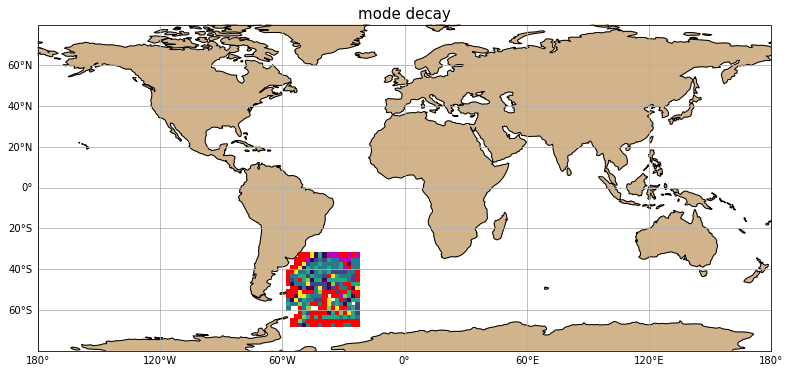

In [31]:
f, ax = plt.subplots(1,1,figsize=(14,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cmap = plt.get_cmap('viridis')
cmap.set_under('r')
cmap.set_over('m')
ax.pcolor(lon_in[data_modes.lon.data],lat_in[data_modes.lat.data],select_mode_i,cmap=cmap,vmin=1,vmax=6)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('mode decay',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
ax.set_xlim([-180,180])
ax.set_ylim([-80,80])

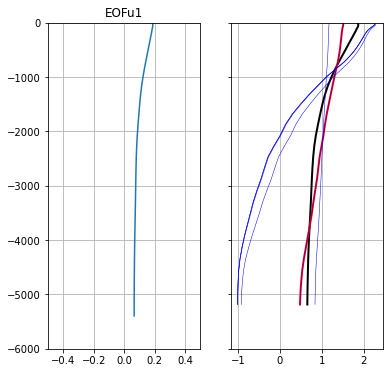

In [40]:
lati = 10
loni = 5
Ki = 0
mi = 1

these_modes = data_modes.modes[lati,loni,0,:,:,1].data # 1st, baroclinic modes (sb + fb)
good = np.where(~np.isnan(these_modes[np.int(data_modes.fbmi[lati,loni]),:]))[0]

this_EOF = np.flip(data.EOFu[:,data_modes.lat[lati].data,data_modes.lon[loni].data])
norm_EOF = this_EOF[good] / np.sqrt(np.trapz((this_EOF[good]*this_EOF[good]), (-1*z[good])) / (1*z[good][0]))
if np.nanmean(norm_EOF[-2:]) < 0:
    norm_EOF = norm_EOF*-1

this_mode = select_mode[lati,loni,:]
norm_mode = this_mode[good] / np.sqrt(np.trapz((this_mode[good]*this_mode[good]), (-1*z[good])) / (1*z[good][0]))

# compare against all other modes 
these_modes = data_modes.modes[lati,loni,0,:,:,1].data
other_norm_modes = np.nan*np.ones((np.shape(these_modes)[0],len(good)))
for k in range(np.shape(these_modes)[0]):
    other_norm_modes[k,:] = these_modes[k,good] / np.sqrt(np.trapz((these_modes[k,good]*these_modes[k,good]), (-1*z[good])) / (1*z[good][0]))

# PLOT 
f, (ax0,ax) = plt.subplots(1,2,figsize=(6,6))
ax0.plot(this_EOF,-1*z)
ax0.set_title('EOFu1')
ax0.set_ylim([-6000,0])
ax0.set_xlim([-.5,.5])
ax0.grid()

ax.plot(norm_EOF,-1*z[good],color='k',linewidth=2)
ax.plot(norm_mode,-1*z[good],color='r',linewidth=2)
for i in range(np.shape(these_modes)[0]):
    ax.plot(other_norm_modes[i,:],-1*z[good],color='b',linewidth=0.5)
# ax.plot(this_mode,-1*z)

# ax.set_title('[' + str(lon_in[lon_i[loni]]) + 'E, ' + str(lat_in[lat_i[lati]]) + 'N], slope=' + \
#              str(np.round(gamma_in[lat_i[lati], lon_i[loni]],4)) + 'e,' + str(np.round(alpha_in[lat_i[lati], lon_i[loni]],4)) + 'n')
ax.set_ylim([-6000,0])
# ax.set_xlim([-.002,0.002])
ax.set_yticklabels([''])
ax.grid()

In [38]:
norm_EOF

<xarray.DataArray 'EOFu' (z: 45)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan])
Coordinates:
  * z        (z) float64 4.556e+03 4.346e+03 4.136e+03 ... 35.36 25.22 15.1
    lat      int64 -32
    lon      int64 336

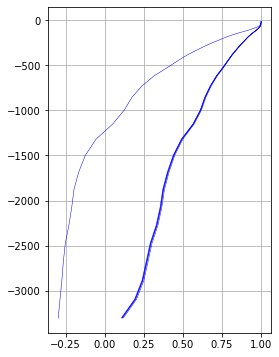

In [12]:
f, ax = plt.subplots(1,1,figsize=(4,6))
for i in range(np.shape(these_modes)[0]):
    # ax.plot(other_norm_modes[i,:],-1*z[good],color='b',linewidth=0.5)
    ax.plot(these_modes[i,:],-1*z,color='b',linewidth=0.5)
ax.grid()

In [105]:
(np.trapz((norm_mode), (-1*z[good])))

0.9999999999999999